In [20]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn import metrics
import sklearn as sk
import matplotlib.pyplot as plt
import random
# %matplotlib inline

In [7]:
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from glob import glob
from scipy import misc
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
import os
from PIL import Image
import gzip
%matplotlib inline

In [127]:
adda = sc.read_h5ad('smaller_dada.h5ad')
gene_names = adda.var.index.tolist()
row_col = adda.obs[['array_row', 'array_col']].values.astype(int)
df = pd.DataFrame(data=np.concatenate((row_col, adda.X), axis=1), columns=['row', 'col'] + gene_names)
df['row'] = df['row'].astype(int)
df['col'] = df['col'].astype(int)

RESIZE_WIDTH = 128
RESIZE_HEIGHT = 64

def resize_gene_maps(gene_map):
    img = Image.fromarray(np.uint8(gene_map * 255) , 'L')
    img = img.resize((RESIZE_WIDTH, RESIZE_HEIGHT))
    img = np.asarray(img) / 255
    return img

def min_max_scale(gm):
    not_nan_values = gm[~np.isnan(gm)]
    mx = not_nan_values.max()
    mn = not_nan_values.min()
    gm = gm - mn
    gm = gm / (mx - mn)
    return gm

def make_gene_map(gene_df, gene_name):
    gm = min_max_scale(gene_df.pivot('row', 'col', gene_name).values)
    gm[np.isnan(gm)] = 0
    gm = gm[1:-1]
    gm = np.concatenate((np.zeros([RESIZE_HEIGHT, RESIZE_WIDTH - gm.shape[1]]), gm), axis=1)
    return gm

# row_len = row_col[:, 0].max() - row_col[:, 0].min() + 1
# col_len = row_col[:, 1].max() - row_col[:, 1].min() + 1
gene_maps = np.zeros([len(gene_names), RESIZE_HEIGHT, RESIZE_WIDTH], dtype=np.float32)
for i, name in enumerate(gene_names):
    gene_maps[i] = make_gene_map(df, name)

## 0. Patch extract

Previous shape:  (64, 128)
extracted patch:  (30, 20)


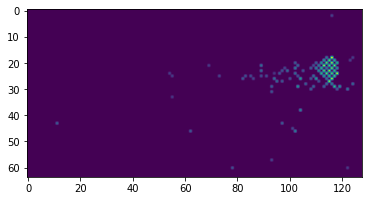

In [130]:
previous_data = gene_maps[gene_names.index('Calml4')]
patch = previous_data[10:40, 100:120]
print('Previous shape: ', previous_data.shape)
print('extracted patch: ', patch.shape)
plt.imshow(previous_data)
plt.show()

## 1. Translation

#### Select number

In [294]:
NUM_PATCH = 3

New position: (34, 32), (54, 2)
New position: (24, 32), (44, 2)


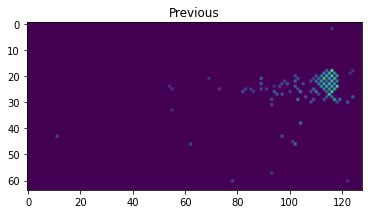

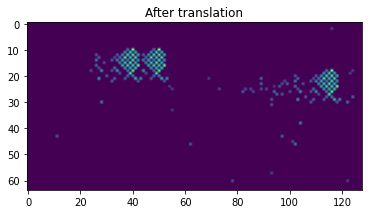

In [296]:
# copy previous data
new_data = np.copy(previous_data)

for times in range(NUM_PATCH-1):
    # define position
    down = random.sample(list(range(0, 34)), 1)[0]
    up = down + patch.shape[0]
    left = random.sample(list(range(20, 100)), 1)[0]
    right = left + patch.shape[1]
    print('New position: ({}, {}), ({}, {})'.format(left, up, right, down))
    new_data[down:up, left:right] = patch

plt.imshow(previous_data)
plt.title('Previous')
plt.show()    
    
plt.imshow(new_data)
plt.title('After translation')
plt.show()

## 2. Add noise

#### Select padding method

Previous shape:  (64, 128)
extracted patch:  (30, 20)
After adding pad:  (40, 30)


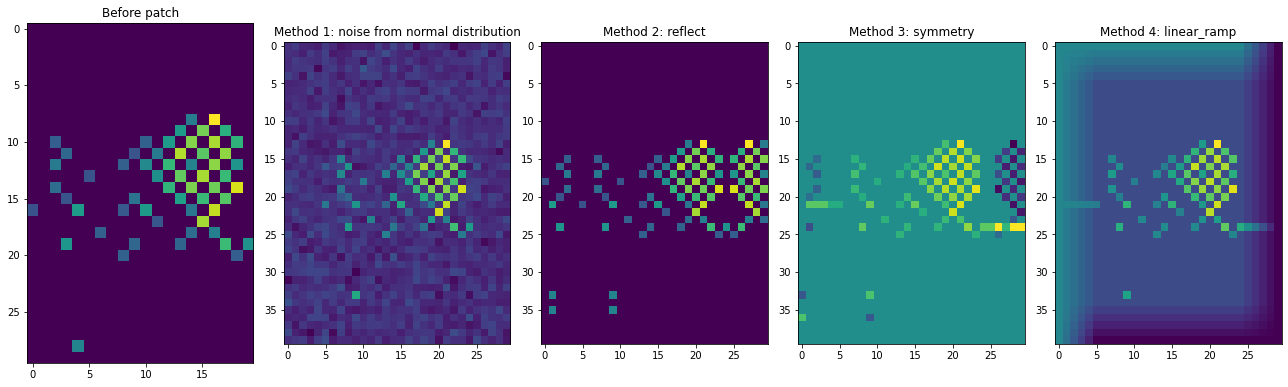

In [285]:
## Add noise from normal distribution
patch_expand_const = np.pad(patch, ((5,5),(5,5)), 'constant', constant_values=0)
noise = np.random.normal(0, .05, patch_expand_const.shape)
patch_expand_const = patch_expand_const + noise
## Other methods
patch_expand_reflect = np.pad(patch, ((5,5),(5,5)), 'reflect')
patch_expand_symmetric = np.pad(patch, ((5,5),(5,5)), 'symmetric', reflect_type='odd')
patch_expand_linear = np.pad(patch, ((5,5),(5,5)), 'linear_ramp', end_values=(0.3, -0.3))
print('Previous shape: ', previous_data.shape)
print('extracted patch: ', patch.shape)
print('After adding pad: ', patch_expand_const.shape)

f, axes = plt.subplots(1,5, figsize=(18, 6))
axes[0].imshow(patch)
axes[0].set_title('Before patch')

axes[1].imshow(patch_expand_const)
axes[1].set_title('Method 1: noise from normal distribution')

axes[2].imshow(patch_expand_reflect)
axes[2].set_title('Method 2: reflect')

axes[3].imshow(patch_expand_symmetric)
axes[3].set_title('Method 3: symmetry')

axes[4].imshow(patch_expand_linear)
axes[4].set_title('Method 4: linear_ramp')
plt.tight_layout()

#### Select patch

In [467]:
after_patch = patch_expand_reflect

New position: (horizontal=80~110), (vertical=10~50)


Text(0.5, 1.0, 'After')

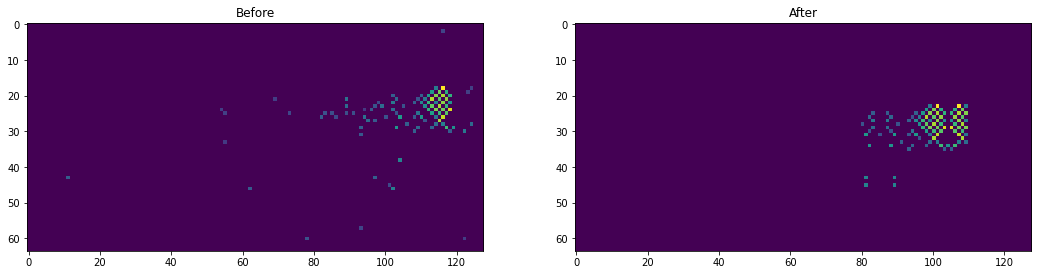

In [468]:
# copy previous data
#new_data = np.copy(previous_data)
new_data = np.zeros(previous_data.shape)

# define position
left = 80
right = left + after_patch.shape[1]
down = 10
up = down + after_patch.shape[0]
print('New position: (horizontal={}~{}), (vertical={}~{})'.format(left, right, down, up))
new_data[down:up, left:right] = after_patch

f, axes = plt.subplots(1,2, figsize=(18, 6))
axes[0].imshow(previous_data)
axes[0].set_title('Before')

axes[1].imshow(new_data)
axes[1].set_title('After')

## 3. Expansion

#### Select ratio

In [225]:
RATIO = 1.5
after_shape = (int(patch.shape[1]*RATIO), int(patch.shape[0]*RATIO))

#### Select padding method

extracted patch:  (30, 20)
expand patch:  (30, 45)


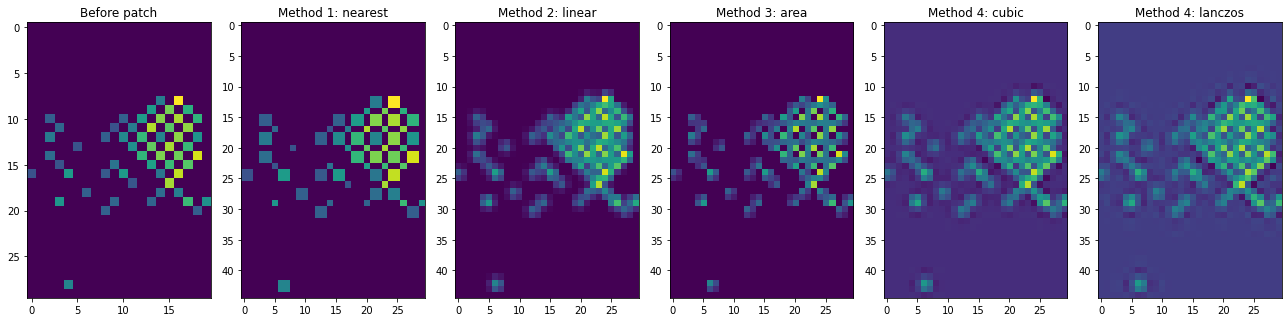

In [226]:
import cv2
patch_resized_near = cv2.resize(patch, dsize=after_shape, interpolation=cv2.INTER_NEAREST)
patch_resized_linear = cv2.resize(patch, dsize=after_shape, interpolation=cv2.INTER_LINEAR)
patch_resized_area = cv2.resize(patch, dsize=after_shape, interpolation=cv2.INTER_AREA)
patch_resized_cubic = cv2.resize(patch, dsize=after_shape, interpolation=cv2.INTER_CUBIC)
patch_resized_lanczos = cv2.resize(patch, dsize=after_shape, interpolation=cv2.INTER_LANCZOS4)
print('extracted patch: ', patch.shape)
print('expand patch: ', after_shape)

f, axes = plt.subplots(1,6, figsize=(18, 6))
axes[0].imshow(patch)
axes[0].set_title('Before patch')

axes[1].imshow(patch_resized_near)
axes[1].set_title('Method 1: nearest')

axes[2].imshow(patch_resized_linear)
axes[2].set_title('Method 2: linear')

axes[3].imshow(patch_resized_area)
axes[3].set_title('Method 3: area')

axes[4].imshow(patch_resized_cubic)
axes[4].set_title('Method 4: cubic')

axes[5].imshow(patch_resized_lanczos)
axes[5].set_title('Method 4: lanczos')
plt.tight_layout()

#### Select patch

In [227]:
after_patch = patch_resized_near

New position: (vertical=72~102), (horizontal=1~46)


Text(0.5, 1.0, 'After')

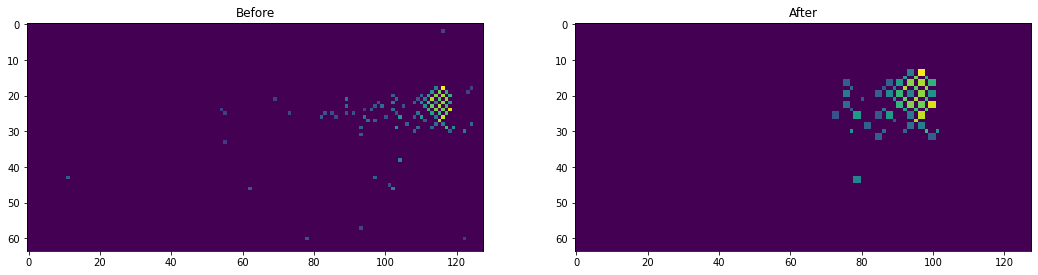

In [263]:
# copy previous data
new_data = np.zeros(previous_data.shape)

# define position
down = random.sample(list(range(0, previous_data.shape[1] - after_shape[0])), 1)[0]
up = down + after_shape[0]
left = random.sample(list(range(0, previous_data.shape[0] - after_shape[1])), 1)[0]
right = left + after_shape[1]
print('New position: (vertical={}~{}), (horizontal={}~{})'.format(down, up, left, right))
new_data[left:right, down:up] = after_patch

f, axes = plt.subplots(1,2, figsize=(18, 6))
axes[0].imshow(previous_data)
axes[0].set_title('Before')

axes[1].imshow(new_data)
axes[1].set_title('After')

## 4. Gaussian version

In [379]:
def makeGaussian2(x_center=0, y_center=0, theta=0, sigma_x=10, sigma_y=10, x_size=128, y_size=64):
    # x_center and y_center will be the center of the gaussian, theta will be the rotation angle
    # sigma_x and sigma_y will be the stdevs in the x and y axis before rotation
    # x_size and y_size give the size of the frame 
    theta = 2*np.pi*theta/360
    x = np.arange(0,x_size, 1, float)
    y = np.arange(0,y_size, 1, float)
    y = y[:,np.newaxis]
    sx = sigma_x
    sy = sigma_y
    x0 = x_center
    y0 = y_center

    # rotation
    a=np.cos(theta)*x -np.sin(theta)*y
    b=np.sin(theta)*x +np.cos(theta)*y
    a0=np.cos(theta)*x0 -np.sin(theta)*y0
    b0=np.sin(theta)*x0 +np.cos(theta)*y0
    return np.exp(-(((a-a0)**2)/(2*(sx**2)) + ((b-b0)**2) /(2*(sy**2))))

#### Set hyper-parameter & check

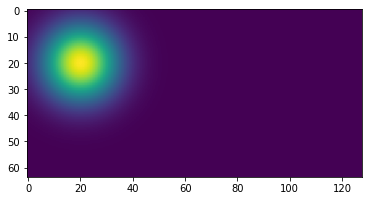

In [441]:
radius_x = 10             # X radius of circle
radius_y = 10             # Y radius of circle
crop_threshold = (radius_x + radius_y)  # don't need to change
Gaussian_circle = makeGaussian2(crop_threshold, crop_threshold, 0, radius_x, radius_y, previous_data.shape[1], previous_data.shape[0])

plt.imshow(Gaussian_circle)
plt.show()

#### Multiple version

In [448]:
# select number
NUM_PATCH = 3

epoch: 3, x=6, y=13
epoch: 3, x=31, y=16
epoch: 3, x=93, y=12


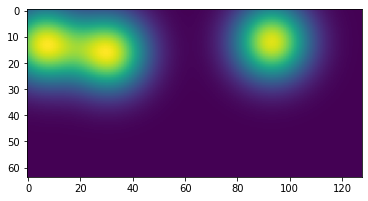

In [449]:
# Blank canvas
canvas = np.zeros(previous_data.shape)

for epoch in range(NUM_PATCH):
    center_x = random.sample(list(range(0, previous_data.shape[1]-radius_x)), 1)[0]
    center_y = random.sample(list(range(0, previous_data.shape[0]-radius_y)), 1)[0]
    print('epoch: {}, x={}, y={}'.format(i, center_x, center_y))
    Gaussian_circle = makeGaussian2(center_x, center_y, 0, radius_x, radius_y, previous_data.shape[1], previous_data.shape[0])
    canvas = canvas + Gaussian_circle
plt.imshow(canvas)
plt.show()

## 5. Inverse-Gaussian

In [461]:
def inverse_makeGaussian2(x_center=0, y_center=0, theta=0, sigma_x=10, sigma_y=10, x_size=128, y_size=64):
    # x_center and y_center will be the center of the gaussian, theta will be the rotation angle
    # sigma_x and sigma_y will be the stdevs in the x and y axis before rotation
    # x_size and y_size give the size of the frame 
    theta = 2*np.pi*theta/360
    x = np.arange(0,x_size, 1, float)
    y = np.arange(0,y_size, 1, float)
    y = y[:,np.newaxis]
    sx = sigma_x
    sy = sigma_y
    x0 = x_center
    y0 = y_center

    # rotation
    a=np.cos(theta)*x -np.sin(theta)*y
    b=np.sin(theta)*x +np.cos(theta)*y
    a0=np.cos(theta)*x0 -np.sin(theta)*y0
    b0=np.sin(theta)*x0 +np.cos(theta)*y0
    return (-1) * np.exp(-(((a-a0)**2)/(2*(sx**2)) + ((b-b0)**2) /(2*(sy**2))))

#### Set hyper-parameter & check

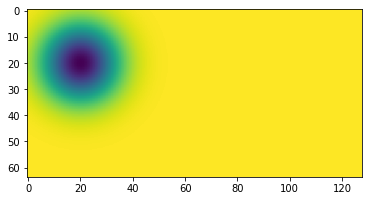

In [463]:
radius_x = 10             # X radius of circle
radius_y = 10             # Y radius of circle
crop_threshold = (radius_x + radius_y)  # don't need to change
inverse_Gaussian_circle = inverse_makeGaussian2(crop_threshold, crop_threshold, 0, radius_x, radius_y, previous_data.shape[1], previous_data.shape[0])

plt.imshow(inverse_Gaussian_circle)
plt.show()

#### Multiple version

In [ ]:
# select number
NUM_PATCH = 3

epoch: 3, x=55, y=50
epoch: 3, x=18, y=5
epoch: 3, x=39, y=1


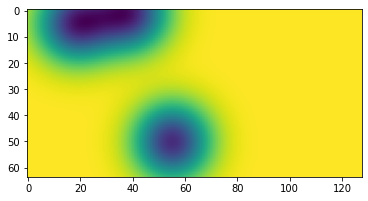

In [464]:
# Blank canvas
canvas = np.zeros(previous_data.shape)

for epoch in range(NUM_PATCH):
    center_x = random.sample(list(range(0, previous_data.shape[1]-radius_x)), 1)[0]
    center_y = random.sample(list(range(0, previous_data.shape[0]-radius_y)), 1)[0]
    print('epoch: {}, x={}, y={}'.format(i, center_x, center_y))
    inverse_Gaussian_circle = inverse_makeGaussian2(center_x, center_y, 0, radius_x, radius_y, previous_data.shape[1], previous_data.shape[0])
    canvas = canvas + inverse_Gaussian_circle
plt.imshow(canvas)
plt.show()